In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [2]:
import sys

import numpy as np
import random 
import tensorflow as tf

from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

utils.reset_seeds(0)

In [3]:
def plot_mean_and_variance(m, X, X_train=np.linspace(-1, 1, 50), y_train=None):
    # for each prediction, plot the mean value and the variance of the prediction
    if y_train is None:
        y_train = X_train**2
        
    y_pred = m.predict(X)
    # print(y_pred)
    y_pred_mean, y_pred_sd = y_pred[:,0], y_pred[:,1]
    y_pred_sd = np.exp(y_pred_sd)
    plt.plot(X, y_pred_mean, label="mean")
    plt.fill_between(X, y_pred_mean - y_pred_sd, y_pred_mean + y_pred_sd, alpha=0.2, label="variance")
    plt.scatter(X_train, y_train, marker='+', color="red", label="train")
    plt.legend()
    plt.show()

In [4]:
def neg_log_likelihood(y_true ,y_predicted):
    y_pred_mean, y_pred_sd = y_predicted[:,0], y_predicted[:,1]


    y_pred_sd = tf.clip_by_value(t=y_pred_sd,
                                   clip_value_min=tf.constant(-15.0),
                                   clip_value_max=tf.constant(+15.0))

    # y_pred_sd ongi log variance
    return tf.reduce_mean(y_pred_sd + tf.math.square((y_pred_mean - y_true) / tf.math.exp(y_pred_sd)))
    

In [6]:
def nll_gaussian(y_test ,y_predicted):
    y_pred_mean, y_pred_sd = y_predicted[:,0], y_predicted[:,1]

    y_pred_sd = tf.clip_by_value(t=tf.exp(y_pred_sd),
                                   clip_value_min=tf.constant(1E-4),
                                   clip_value_max=tf.constant(1E+100))

    ## element wise square
    square = tf.square(y_pred_mean - y_test)## preserve the same shape as y_pred.shape
    ms = tf.add(tf.divide(square,y_pred_sd), tf.math.log(y_pred_sd))
    ## axis = -1 means that we take mean across the last dimension 
    ## the output keeps all but the last dimension
    ## ms = tf.reduce_mean(ms,axis=-1)
    ## return scalar
    ms = tf.reduce_mean(ms)
    return(ms)


Epoch:   0 | Loss: -7.04349e-01
Epoch: 100 | Loss: -1.39920e+00
Epoch: 200 | Loss: -1.42263e+00
Epoch: 300 | Loss: -1.42207e+00
Epoch: 400 | Loss: -1.42279e+00
Epoch: 500 | Loss: -1.42913e+00
Epoch: 600 | Loss: -1.43027e+00
Epoch: 700 | Loss: -1.42596e+00
Epoch: 800 | Loss: -1.43243e+00
Epoch: 900 | Loss: -1.43112e+00
313/313 [==============================] - 1s 2ms/step


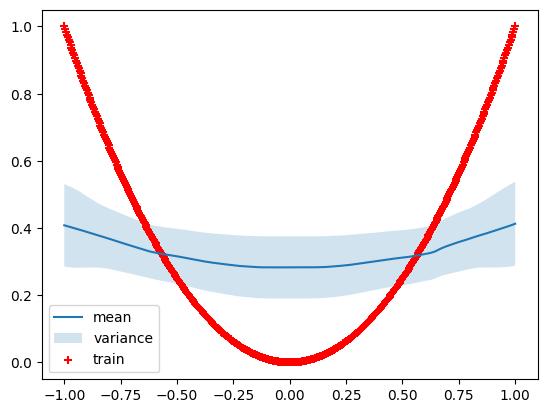

In [11]:
utils.reset_seeds(2002)

model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(units=500, activation='relu', name="layer_1"),
    layers.Dense(units=300, activation='relu', name="layer_2"),
    layers.Dense(units=100, activation='relu', name="layer_3"),
    layers.Dense(units=2, activation='linear', name="layer_4")#, kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)),
])
# last_layer = model.get_layer('layer_3')
# l_w = last_layer.get_weights()


X = np.linspace(-1, 1, 500)
y = X**2
X_train, y_train = X, y
X_valid, y_valid = np.linspace(-1, 1, 10000), np.linspace(-1, 1, 10000)**2

model.compile(
    optimizer=keras.optimizers.Adam(
       learning_rate=0.001, amsgrad=True, epsilon=0.001),
    loss=nll_gaussian,
    # metrics=[keras.metrics.MeanSquaredError()],
)

h = model.fit(X, y, batch_size=8, epochs=1000, verbose=0,
                callbacks=[CustomLogger(100)], shuffle=True)


plot_mean_and_variance(model, X_valid, X_train)

## Blogijast 

In [22]:
def weight_variable(shape):
    ## weight variable, initialized with truncated normal distribution
    initial = tf.random.truncated_normal(shape, stddev=0.01, dtype="float64")
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.001, shape=shape, dtype="float64")
    return tf.Variable(initial)
    
def fully_connected_layer(h0,n_h0,n_h1,verbose=True):
    '''
    h0   :  tensor of shape (n_h0, n_h1)
    n_h0 :  scalar 
    n_h1 :  scalar
    '''
    W1 = weight_variable([n_h0, n_h1])
    b1 =  bias_variable([n_h1])
    
    if verbose:
        print("    h0.shape={}".format(h0.get_shape()))
        print("    W1.shape={}".format(W1.get_shape()))
        print("    b1.shape={}".format(b1.get_shape()))
    
    h1 = tf.linalg.matmul(h0, W1) + b1
    return(h1, (W1,b1))

In [24]:
def nll_gaussian(y_pred_mean,y_pred_sd,y_test):

    ## element wise square
    square = tf.square(y_pred_mean - y_test)## preserve the same shape as y_pred.shape
    ms = tf.add(tf.divide(square,y_pred_sd), tf.log(y_pred_sd))
    ## axis = -1 means that we take mean across the last dimension 
    ## the output keeps all but the last dimension
    ## ms = tf.reduce_mean(ms,axis=-1)
    ## return scalar
    ms = tf.reduce_mean(ms)
    return(ms)

def define_model(n_feature,n_hs,n_output,verbose=True,NLL=True):
    
    x_input = tf.keras.Input(dtype=tf.float64, shape=[None, n_feature])
    y_input = tf.keras.Input(dtype=tf.float64, shape=[None, 1])
    
    h_previous = x_input
    n_h_previous = n_feature
    paras = []
    for ilayer,n_h in enumerate(n_hs,1):
        print(ilayer, n_h)
        if verbose:
            print("  layer:{}".format(ilayer))
        h, p = fully_connected_layer(h_previous,n_h_previous,n_h,verbose)
        h_previous = tf.nn.relu(h) 
        n_h_previous = n_h
        paras.append(p)
    if verbose:
        print("  output layer for y_mean")        
    y_mean,p = fully_connected_layer(h_previous,n_h_previous,n_output,verbose)
    paras.append(p)
    

    if verbose:
        print("  output layer for y_sigma")  
    y_sigma, p = fully_connected_layer(h_previous,n_h_previous,n_output,verbose)
    ## for numerical stability this enforce the variance to be more than 1E-4
    y_sigma = tf.clip_by_value(t=tf.exp(y_sigma),
                                clip_value_min=tf.constant(1E-4),
                                clip_value_max=tf.constant(1E+100))

    paras.append(p)   
    loss = nll_gaussian(y_mean, y_sigma,y_input)
    y = [y_mean, y_sigma]

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    inputs = [x_input, y_input]
    
    return(loss, train_step, inputs, y, paras)
print("___"*10)
print("loss=NLL")
loss, train_step, inputs, y, _ = define_model(n_feature=1,
                                              n_hs=[500,300,100],
                                              n_output = 1)

[x_input, _] = inputs
[y_mean, y_sigma] = y

______________________________
loss=NLL
1 500
  layer:1
    h0.shape=(None, None, 1)
    W1.shape=(1, 500)
    b1.shape=(500,)
2 300
  layer:2
    h0.shape=(None, None, 500)
    W1.shape=(500, 300)
    b1.shape=(300,)
3 100
  layer:3
    h0.shape=(None, None, 300)
    W1.shape=(300, 100)
    b1.shape=(100,)
  output layer for y_mean
    h0.shape=(None, None, 100)
    W1.shape=(100, 1)
    b1.shape=(1,)
  output layer for y_sigma
    h0.shape=(None, None, 100)
    W1.shape=(100, 1)
    b1.shape=(1,)


ValueError: Can't convert Python sequence with a value out of range for a double-precision float.

In [159]:
from keras.layers import Input, Dense


def nll_gaussian(y_pred, y_test):  # y_test
    y_pred_mean, y_pred_sd = y_pred[0], y_pred[1]
    #tf.print(y_test)
    # element wise square
    # preserve the same shape as y_pred.shape
    y_pred_sd = tf.clip_by_value(t=y_pred_sd,
                                    clip_value_min=tf.constant(1E-4),
                                    clip_value_max=tf.constant(1E+100))

    square = tf.square(y_pred_mean - y_test)
    ms = tf.add(tf.divide(square, y_pred_sd), tf.math.log(y_pred_sd))
    #tf.print(y_pred, summarize=-1)

    # axis = -1 means that we take mean across the last dimension
    # the output keeps all but the last dimension
    ## ms = tf.reduce_mean(ms,axis=-1)
    # return scalar
    return tf.reduce_mean(ms)


def define_model():

    Input_1 = Input(shape=(1,))

    x = Dense(500, activation='relu')(Input_1)
    x = Dense(300, activation='relu')(x)
    x = Dense(100, activation='relu')(x)

    out1 = Dense(1,  activation='linear')(x)
    out2 = Dense(1,  activation='linear')(x)

    model = tf.keras.Model(inputs=Input_1, outputs=[out1, out2])
    # keras.losses.MeanSquaredError())#nll_gaussian)
    model.compile(optimizer="adam", loss=nll_gaussian)
    return model

utils.reset_seeds(0)
model = define_model()

X = np.linspace(-1, 1, 10)
y = X**2

#x_train,y_train

model.fit(x_train,y_train, batch_size=4, epochs=8000, verbose=0,
          callbacks=[CustomLogger(100)])
    
# model.summary()


Epoch:   0 | Loss: 2.32023e+04
Epoch: 100 | Loss: 2.14203e+04
Epoch: 200 | Loss: 2.21333e+04
Epoch: 300 | Loss: 2.01391e+04
Epoch: 400 | Loss: 2.17890e+04
Epoch: 500 | Loss: 2.17549e+04
Epoch: 600 | Loss: 2.08462e+04
Epoch: 700 | Loss: 2.15638e+04
Epoch: 800 | Loss: 2.03069e+04
Epoch: 900 | Loss: 2.22323e+04
Epoch: 1000 | Loss: 1.89431e+04
Epoch: 1100 | Loss: 2.12887e+04
Epoch: 1200 | Loss: 1.98446e+04
Epoch: 1300 | Loss: 1.90354e+04
Epoch: 1400 | Loss: 2.08999e+04
Epoch: 1500 | Loss: 1.91507e+04
Epoch: 1600 | Loss: 2.16483e+04
Epoch: 1700 | Loss: 2.07532e+04
Epoch: 1800 | Loss: 2.13252e+04
Epoch: 1900 | Loss: 2.03985e+04
Epoch: 2000 | Loss: 1.94274e+04
Epoch: 2100 | Loss: 2.01099e+04
Epoch: 2200 | Loss: 2.07892e+04
Epoch: 2300 | Loss: 2.29184e+04
Epoch: 2400 | Loss: 2.06851e+04
Epoch: 2500 | Loss: 2.06042e+04
Epoch: 2600 | Loss: 2.05007e+04
Epoch: 2700 | Loss: 2.08050e+04
Epoch: 2800 | Loss: 2.08538e+04
Epoch: 2900 | Loss: 2.03283e+04
Epoch: 3000 | Loss: 2.16388e+04
Epoch: 3100 | Loss

In [149]:
def plot_mean_and_variance_temp(m, X, X_train=np.linspace(-1, 1, 50), y_train=None):
    # for each prediction, plot the mean value and the variance of the prediction
    if y_train is None:
        y_train = X_train**2
        
    y_pred = m.predict(X)

    y_pred_mean, y_pred_sd = y_pred[0], y_pred[1]
    y_pred_sd = np.exp(y_pred_sd)

    plt.plot(X, y_pred_mean, label="mean")
    print((y_pred_mean - y_pred_sd).flatten())
    print(( y_pred_mean + y_pred_sd).flatten())
    plt.fill_between(X, (y_pred_mean - y_pred_sd).flatten(), (y_pred_mean + y_pred_sd).flatten(), alpha=0.2, label="variance")
    plt.scatter(X_train, y_train, marker='+', color="red", label="train")
    plt.legend()
    plt.show()

157/157 [==============================] - 0s 3ms/step
5000
5000
[-1.4048105 -1.403916  -1.4030225 ... -1.1765919 -1.1768384 -1.1770859]
[ 2.970447    2.9680448   2.9656432  ... -0.14233369 -0.14310789
 -0.14388448]


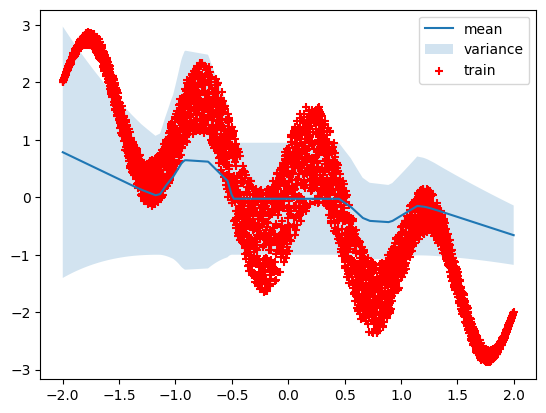

In [158]:
X = np.linspace(-2, 2, 50)
y = X**2
X_valid = np.linspace(-2, 2, 5000)
plot_mean_and_variance_temp(model, X_valid, x_train,y_train)

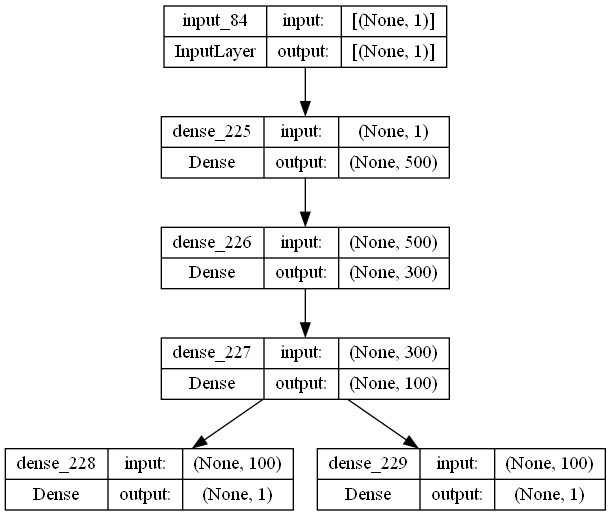

In [111]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [152]:
x_train =np.arange(-2,2,0.001)
x_train = x_train.reshape(len(x_train),1)
steps_per_cycle = 1
def sinfun(xs,noise=0.001):
    import random, math
    xs = xs.flatten()
    def randomNoise(x):
        ax = 2 - np.abs(x)
        wnoise = random.uniform(-noise*ax, 
                                 noise*ax)
        return(math.sin(x * (2 * math.pi / steps_per_cycle) ) + wnoise)
    vec = [randomNoise(x) - x  for x in xs]
    return(np.array(vec).flatten())

y_train0 =  sinfun(x_train,noise=0.5) 
y_train = y_train0.reshape(len(y_train0),1)

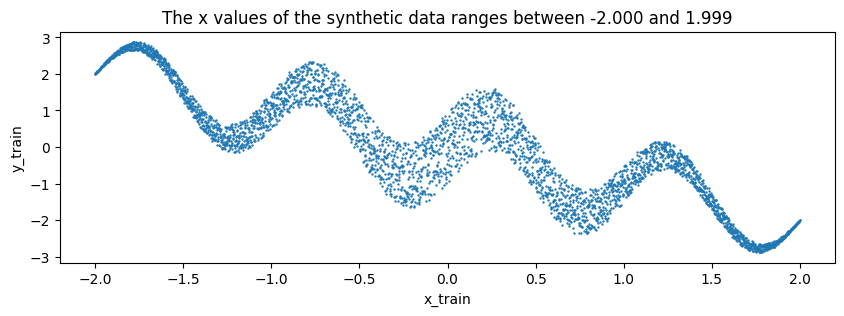

In [153]:
## Visualize the generated data (X,y)
plt.figure(figsize=(10,3))
plt.scatter(x_train,y_train,s=0.5)
plt.xlabel("x_train")
plt.ylabel("y_train")
plt.title("The x values of the synthetic data ranges between {:4.3f} and {:4.3f}".format(
    np.min(x_train),np.max(x_train)))
plt.show()